In [33]:
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

root = Path("../Playing cards.v10i.yolov8")
yaml_path = root / "data.yaml"

with open(yaml_path, "r") as f:
    cfg = yaml.safe_load(f)

classes = cfg["names"]
print(f"Found {len(classes)} classes")
print(classes)

train_dir = root / "train"
val_dir   = root / "valid"
test_dir  = root / "test"

print("\nDataset directories:")
print("train:", train_dir)
print("valid:", val_dir)
print("test :", test_dir)


Found 55 classes
['h10', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'ha', 'hb', 'hh', 'hv', 'j', 'k10', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'ka', 'kb', 'kh', 'kv', 'pile-face-down', 'pile-face-up', 'r10', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'ra', 'rb', 'rh', 'rv', 's10', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 'sa', 'sb', 'sh', 'sv']

Dataset directories:
train: ..\Playing cards.v10i.yolov8\train
valid: ..\Playing cards.v10i.yolov8\valid
test : ..\Playing cards.v10i.yolov8\test


In [32]:
def scan_dataset():
    """Return fresh lists of images + labels for all splits."""
    def get(split, kind):
        return list((root / split / kind).glob("*.jpg")) if kind=="images" \
            else list((root / split / kind).glob("*.txt"))

    train_imgs = get("train", "images")
    val_imgs   = get("valid", "images")
    test_imgs  = get("test", "images")

    train_lbls = get("train", "labels")
    val_lbls   = get("valid", "labels")
    test_lbls  = get("test", "labels")

    label_files = train_lbls + val_lbls + test_lbls
    img_paths   = train_imgs + val_imgs + test_imgs

    return img_paths, label_files, (train_imgs, val_imgs, test_imgs), (train_lbls, val_lbls, test_lbls)

# initial scan
img_paths, label_files, (train_imgs, val_imgs, test_imgs), (train_lbls, val_lbls, test_lbls) = scan_dataset()


In [4]:
polygon_files = []
total_labels = 0

for split in ["train", "valid", "test"]:
    label_dir = root / split / "labels"
    for lf in label_dir.glob("*.txt"):
        total_labels += 1
        lines = lf.read_text().strip().splitlines()
        for line in lines:
            parts = line.split()
            if len(parts) != 5:  # YOLO has exactly 5 values per line
                polygon_files.append(lf)
                break

print("=================================")
print(" Polygon Detection Report")
print("=================================")
print("Total label files:", total_labels)
print("Files with polygons:", len(polygon_files))
print(f"Percentage affected: {len(polygon_files)/total_labels*100:.2f}%")

polygon_files[:10]  # preview


 Polygon Detection Report
Total label files: 2430
Files with polygons: 94
Percentage affected: 3.87%


[WindowsPath('../Playing cards.v10i.yolov8/train/labels/VID_20230227_221709_mp4-0_jpg.rf.07f555c971a4d75d32f113f09aa056ed.txt'),
 WindowsPath('../Playing cards.v10i.yolov8/train/labels/VID_20230227_221709_mp4-0_jpg.rf.685f8818b053da92eeeca5b568f144b7.txt'),
 WindowsPath('../Playing cards.v10i.yolov8/train/labels/VID_20230227_221709_mp4-0_jpg.rf.ddf91eda623c8c8e03b9ab52565a3ce2.txt'),
 WindowsPath('../Playing cards.v10i.yolov8/train/labels/VID_20230227_221709_mp4-19_jpg.rf.12f7506f077b0e23fd090b4e91e2154c.txt'),
 WindowsPath('../Playing cards.v10i.yolov8/train/labels/VID_20230227_221709_mp4-19_jpg.rf.5b1604756fb05bfd96effbb40af5b202.txt'),
 WindowsPath('../Playing cards.v10i.yolov8/train/labels/VID_20230227_221709_mp4-1_jpg.rf.5730e9c1ed9c5474ee5fc8ce46d051b4.txt'),
 WindowsPath('../Playing cards.v10i.yolov8/train/labels/VID_20230227_221709_mp4-1_jpg.rf.cfaf6fd19f06d3c3ccdaf281f336a318.txt'),
 WindowsPath('../Playing cards.v10i.yolov8/train/labels/VID_20230227_221709_mp4-20_jpg.rf.6daae

In [5]:
from pathlib import Path

print("\n=== Removing polygon samples ===\n")

deleted_labels = 0
deleted_images = 0

for lf in polygon_files:

    # Delete label file
    lf.unlink(missing_ok=True)
    deleted_labels += 1

    # Compute matching image path
    img_jpg = Path(str(lf).replace("labels", "images")).with_suffix(".jpg")
    img_png = img_jpg.with_suffix(".png")

    if img_jpg.exists():
        img_jpg.unlink()
        deleted_images += 1
    elif img_png.exists():
        img_png.unlink()
        deleted_images += 1

print("Deleted labels:", deleted_labels)
print("Deleted images:", deleted_images)



=== Removing polygon samples ===

Deleted labels: 94
Deleted images: 94


In [3]:
# --- Use existing variables: root, classes, train_dir, val_dir, test_dir ---

# Identify pile-class IDs
pile_names = {"pile-face-up", "pile-face-down"}
pile_ids = {i for i, n in enumerate(classes) if n in pile_names}

print("Pile class IDs:", pile_ids)

total_label_files = 0
total_annotations = 0

files_with_pile = 0
annotations_with_pile = 0

# Iterate over all three splits
for split_dir in [train_dir, val_dir, test_dir]:
    for lf in (split_dir / "labels").glob("*.txt"):

        total_label_files += 1
        lines = lf.read_text().splitlines()

        file_has_pile = False

        for line in lines:
            parts = line.split()
            cls = int(parts[0])
            total_annotations += 1

            if cls in pile_ids:
                annotations_with_pile += 1
                file_has_pile = True

        if file_has_pile:
            files_with_pile += 1

print("================================")
print("        PILE LABEL REPORT       ")
print("================================")
print(f"Total label files: {total_label_files}")
print(f"Files containing pile labels: {files_with_pile}")
print(f"Percentage of affected files: {files_with_pile/total_label_files*100:.2f}%")

print()
print(f"Total annotations: {total_annotations}")
print(f"Pile annotations: {annotations_with_pile}")
print(f"Percentage of pile annotations: {annotations_with_pile/total_annotations*100:.2f}%")


Pile class IDs: {27, 28}
        PILE LABEL REPORT       
Total label files: 2336
Files containing pile labels: 1665
Percentage of affected files: 71.28%

Total annotations: 66199
Pile annotations: 3546
Percentage of pile annotations: 5.36%


In [4]:
# Remove only pile labels from annotation files

pile_ids = {i for i, n in enumerate(classes) if n in {"pile-face-up", "pile-face-down"}}
print("Pile IDs to remove:", pile_ids)

cleaned_files = 0
removed_annotations = 0

for split_dir in [train_dir, val_dir, test_dir]:
    label_dir = split_dir / "labels"
    for lf in label_dir.glob("*.txt"):

        lines = lf.read_text().splitlines()
        new_lines = []

        for line in lines:
            cls = int(line.split()[0])
            if cls not in pile_ids:
                new_lines.append(line)
            else:
                removed_annotations += 1

        # Write back modified content
        lf.write_text("\n".join(new_lines))

        cleaned_files += 1

print("\n======================================")
print("         PILE LABEL REMOVAL DONE      ")
print("======================================")
print(f"Label files processed: {cleaned_files}")
print(f"Pile annotations removed: {removed_annotations}")


Pile IDs to remove: {27, 28}

         PILE LABEL REMOVAL DONE      
Label files processed: 2336
Pile annotations removed: 3546


In [5]:
# Re-run the pile report to confirm everything is removed
files_with_pile = 0
annotations_with_pile = 0

for split_dir in [train_dir, val_dir, test_dir]:
    for lf in (split_dir / "labels").glob("*.txt"):
        for line in lf.read_text().splitlines():
            cls = int(line.split()[0])
            if cls in pile_ids:
                files_with_pile += 1
                annotations_with_pile += 1

print("Files still containing pile labels:", files_with_pile)
print("Pile annotations remaining:", annotations_with_pile)


Files still containing pile labels: 0
Pile annotations remaining: 0


In [7]:
from pathlib import Path

root = Path("../Playing cards.v10i.yolov8")

splits = ["train", "valid", "test"]

for split in splits:
    img_dir = root / split / "images"
    lbl_dir = root / split / "labels"

    imgs = list(img_dir.glob("*.jpg"))
    lbls = list(lbl_dir.glob("*.txt"))

    empty = 0
    nonempty = 0

    for lf in lbls:
        if lf.read_text().strip() == "":
            empty += 1
        else:
            nonempty += 1

    print(f"\n=== {split.upper()} ===")
    print("Images      :", len(imgs))
    print("Labels      :", len(lbls))
    print("Non-empty   :", nonempty)
    print("Empty       :", empty)



=== TRAIN ===
Images      : 1964
Labels      : 1964
Non-empty   : 1855
Empty       : 109

=== VALID ===
Images      : 241
Labels      : 241
Non-empty   : 231
Empty       : 10

=== TEST ===
Images      : 131
Labels      : 131
Non-empty   : 123
Empty       : 8


Found 127 empty-label images.
Displaying 12 empty-label images...



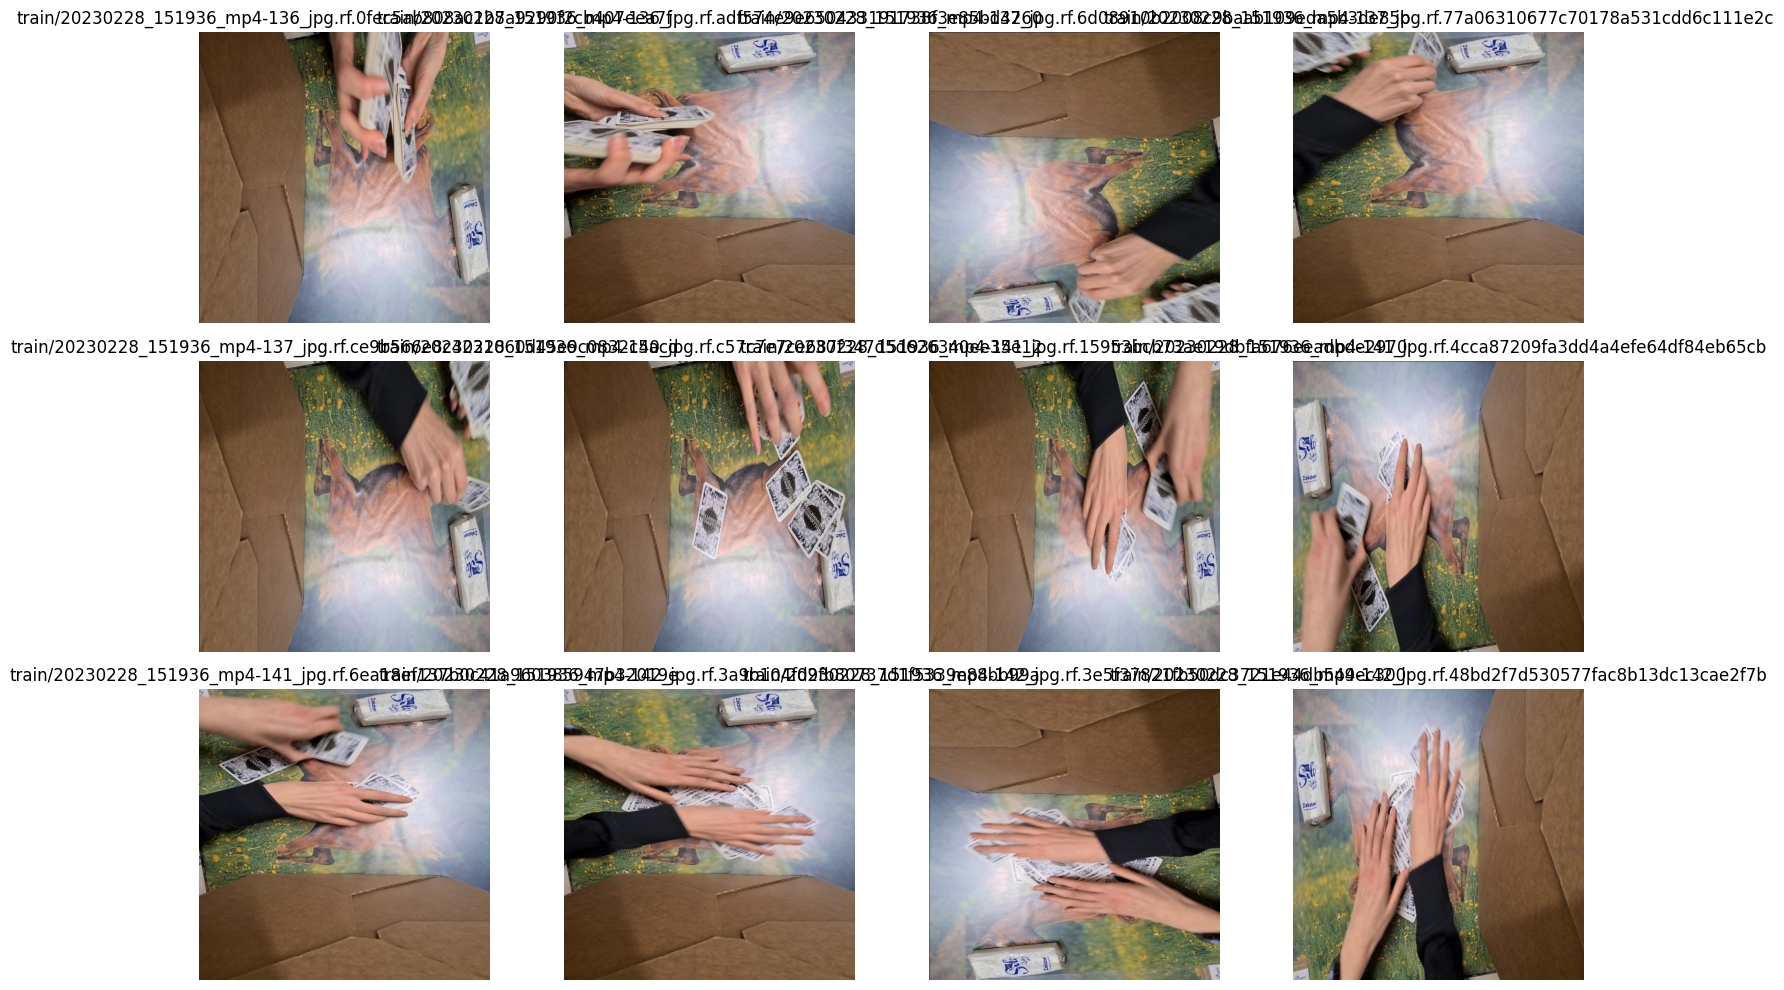

In [12]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

root = Path("../Playing cards.v10i.yolov8")

splits = ["train", "valid", "test"]

empty_images = []  # store (img_path, label_path)

for split in splits:
    img_dir = root / split / "images"
    lbl_dir = root / split / "labels"

    for lbl_file in lbl_dir.glob("*.txt"):
        if lbl_file.read_text().strip() == "":
            # Find matching image (jpg or png)
            img_jpg = img_dir / (lbl_file.stem + ".jpg")
            img_png = img_dir / (lbl_file.stem + ".png")

            if img_jpg.exists():
                empty_images.append((img_jpg, lbl_file))
            elif img_png.exists():
                empty_images.append((img_png, lbl_file))

print(f"Found {len(empty_images)} empty-label images.")

# ---- Display some examples ----

N = min(12, len(empty_images))
print(f"Displaying {N} empty-label images...\n")

plt.figure(figsize=(15, 10))

for i in range(N):
    img_path, lbl_path = empty_images[i]

    img = Image.open(img_path)

    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f"{lbl_path.parent.parent.name}/{img_path.stem}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [13]:
from pathlib import Path

root = Path("../Playing cards.v10i.yolov8")

splits = ["train", "valid", "test"]

deleted_images = 0
deleted_labels = 0

for split in splits:
    img_dir = root / split / "images"
    lbl_dir = root / split / "labels"

    for lbl_file in lbl_dir.glob("*.txt"):
        if lbl_file.read_text().strip() == "":
            # Delete label file
            lbl_file.unlink(missing_ok=True)
            deleted_labels += 1

            # Matching image
            img_jpg = img_dir / (lbl_file.stem + ".jpg")
            img_png = img_dir / (lbl_file.stem + ".png")

            if img_jpg.exists():
                img_jpg.unlink()
                deleted_images += 1
            elif img_png.exists():
                img_png.unlink()
                deleted_images += 1

print("=====================================")
print("      EMPTY LABEL CLEANUP REPORT     ")
print("=====================================")
print(f"Deleted label files : {deleted_labels}")
print(f"Deleted images      : {deleted_images}")
print("=====================================")


      EMPTY LABEL CLEANUP REPORT     
Deleted label files : 127
Deleted images      : 127


In [15]:
from pathlib import Path

root = Path("../Playing cards.v10i.yolov8")

def get_images(split):
    return list((root / split / "images").glob("*.jpg"))

def get_labels(split):
    return list((root / split / "labels").glob("*.txt"))

train_imgs = get_images("train")
val_imgs   = get_images("valid")
test_imgs  = get_images("test")

train_lbls = get_labels("train")
val_lbls   = get_labels("valid")
test_lbls  = get_labels("test")

print("=== Dataset after cleaning ===")
print("Train images:", len(train_imgs), "| Train labels:", len(train_lbls))
print("Valid images:", len(val_imgs),   "| Valid labels:", len(val_lbls))
print("Test images :", len(test_imgs),  "| Test labels :", len(test_lbls))


=== Dataset after cleaning ===
Train images: 1855 | Train labels: 1855
Valid images: 231 | Valid labels: 231
Test images : 123 | Test labels : 123


In [16]:
# RESCAN EVERYTHING
train_imgs = get_images("train")
val_imgs   = get_images("valid")
test_imgs  = get_images("test")

train_lbls = get_labels("train")
val_lbls   = get_labels("valid")
test_lbls  = get_labels("test")

label_files = train_lbls + val_lbls + test_lbls
img_paths   = train_imgs + val_imgs + test_imgs


In [17]:
counts = [0] * len(classes)

for lf in label_files:
    for line in lf.read_text().strip().splitlines():
        cls = int(line.split()[0])
        counts[cls] += 1

df = pd.DataFrame({"class": classes, "count": counts})
df_sorted = df.sort_values("count", ascending=False)

df_sorted


class  count
13               j   2388
51              sa   1868
37              r9   1837
16              k3   1623
26              kv   1594
23              ka   1575
38              ra   1558
52              sb   1546
35              r7   1537
9               ha   1415
39              rb   1341
25              kh   1334
1               h2   1302
10              hb   1281
30              r2   1278
54              sv   1242
3               h4   1240
41              rv   1226
22              k9   1220
2               h3   1215
0              h10   1202
44              s3   1202
45              s4   1180
29             r10   1169
11              hh   1145
4               h5   1143
7               h8   1134
12              hv   1120
17              k4   1072
50              s9   1072
43              s2   1034
48              s7   1032
34              r6   1025
18              k5   1018
53              sh   1016
46              s5   1011
49              s8   1006
19              k6   1003
24              kb    991
32              r4    958
6               h7    954
8               h9    936
33              r5    933
42             s10    928
15              k2    916
40              rh    907
21              k8    905
36              r8    866
20              k7    861
14             k10    855
47              s6    845
31              r3    843
5               h6    751
28    pile-face-up      0
27  pile-face-down      0

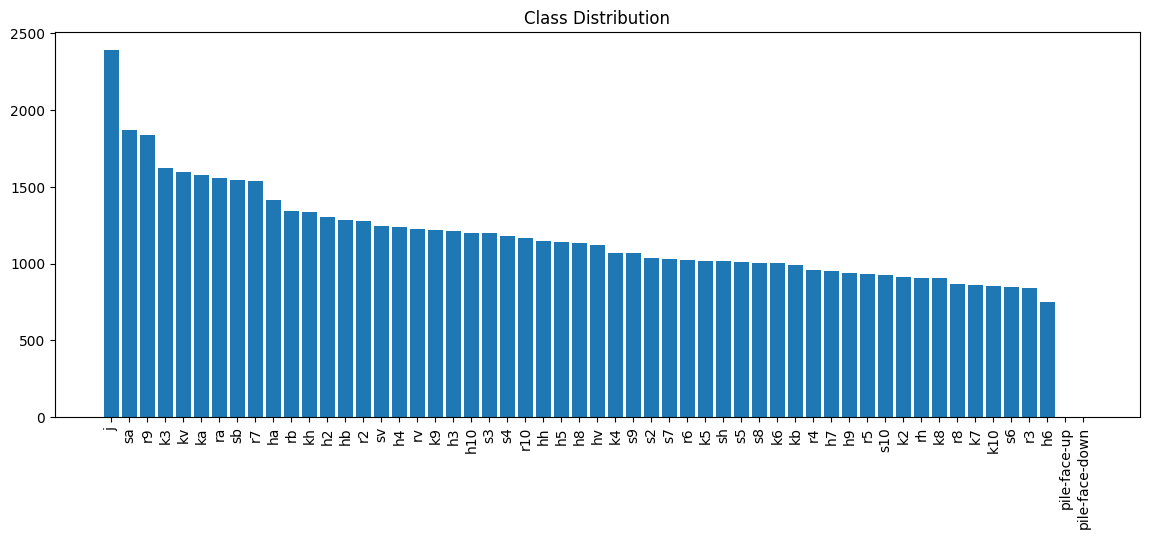

In [18]:
plt.figure(figsize=(14,5))
plt.bar(df_sorted["class"], df_sorted["count"])
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.show()


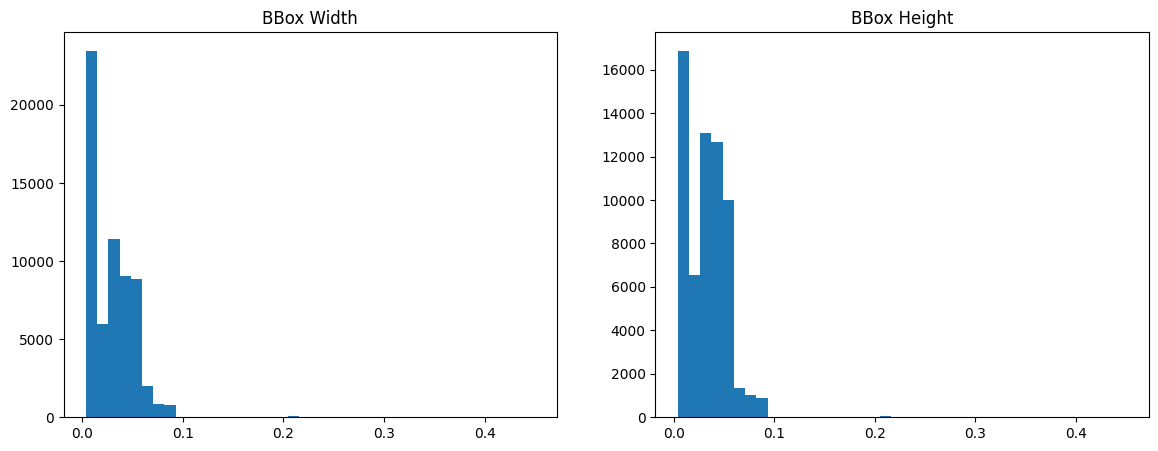

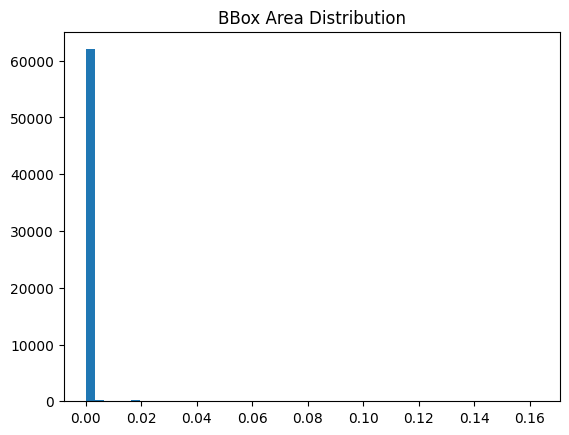

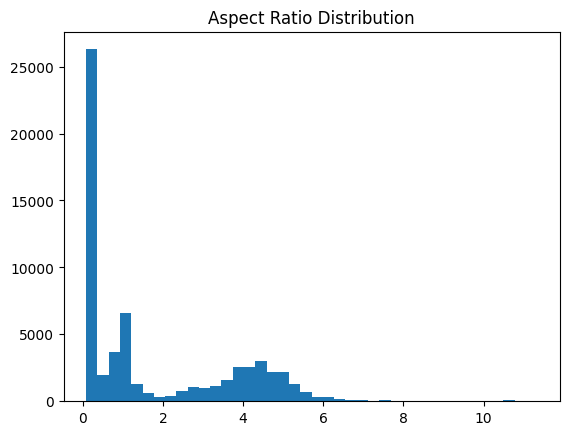

In [19]:
widths, heights = [], []

for lf in label_files:
    for line in lf.read_text().splitlines():
        cls, xc, yc, w, h = map(float, line.split())
        widths.append(w)
        heights.append(h)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(widths, bins=40)
plt.title("BBox Width")

plt.subplot(1,2,2)
plt.hist(heights, bins=40)
plt.title("BBox Height")
plt.show()

areas = [w*h for w,h in zip(widths, heights)]

plt.hist(areas, bins=50)
plt.title("BBox Area Distribution")
plt.show()

aspect_ratios = [w/h for w,h in zip(widths, heights)]
plt.hist(aspect_ratios, bins=40)
plt.title("Aspect Ratio Distribution")
plt.show()


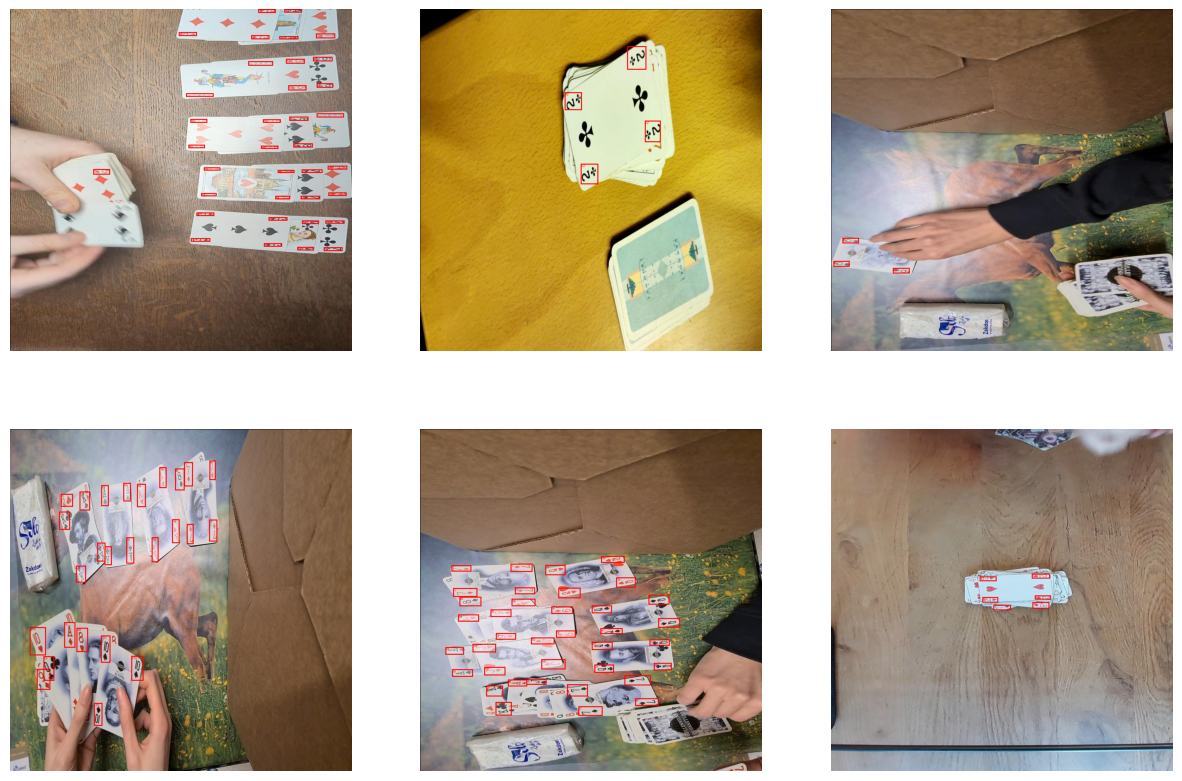

In [20]:
from PIL import ImageDraw, ImageFont
import random

def draw_boxes(img_path, label_path):
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    w, h = img.size

    with open(label_path, "r") as f:
        for line in f:
            cls, xc, yc, bw, bh = map(float, line.split())
            x1 = (xc - bw/2) * w
            y1 = (yc - bh/2) * h
            x2 = (xc + bw/2) * w
            y2 = (yc + bh/2) * h

            draw.rectangle([x1,y1,x2,y2], outline="red", width=3)
            draw.text((x1, y1), classes[int(cls)], fill="red")

    return img

sample_paths = random.sample(img_paths, 6)

plt.figure(figsize=(15,10))
for i, img_p in enumerate(sample_paths):
    lbl_p = img_p.parent.parent/"labels"/(img_p.stem + ".txt")
    im = draw_boxes(img_p, lbl_p)

    plt.subplot(2,3,i+1)
    plt.imshow(im)
    plt.axis("off")

plt.show()


In [22]:
# Rebuild center coordinate lists
xc_list = []
yc_list = []

for lf in label_files:
    for line in lf.read_text().splitlines():
        cls, xc, yc, w, h = map(float, line.split())
        xc_list.append(xc)
        yc_list.append(yc)

print("Collected centers:", len(xc_list))


Collected centers: 62653


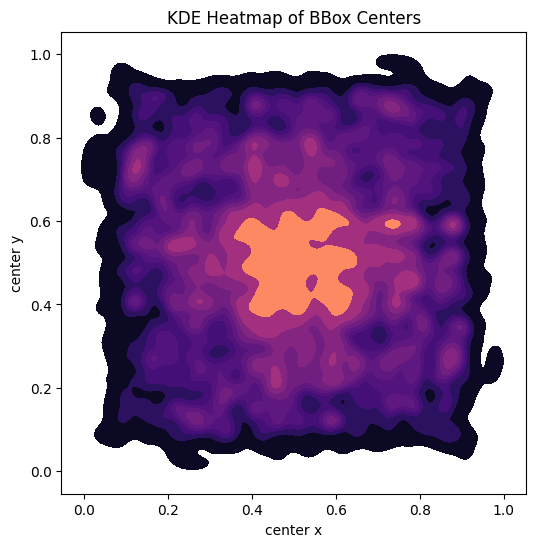

In [23]:
import seaborn as sns
import numpy as np

plt.figure(figsize=(6,6))
sns.kdeplot(x=xc_list, y=yc_list, cmap="magma", fill=True, bw_adjust=0.5)
plt.title("KDE Heatmap of BBox Centers")
plt.xlabel("center x")
plt.ylabel("center y")
plt.show()


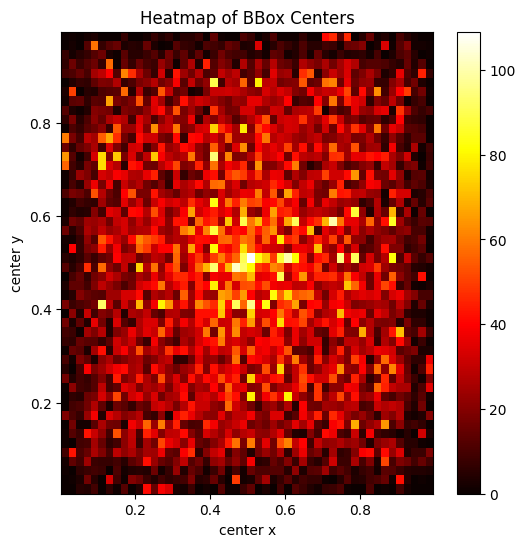

In [25]:
plt.figure(figsize=(6,6))
plt.hist2d(xc_list, yc_list, bins=50, cmap='hot')
plt.colorbar()
plt.title("Heatmap of BBox Centers")
plt.xlabel("center x")
plt.ylabel("center y")
plt.show()


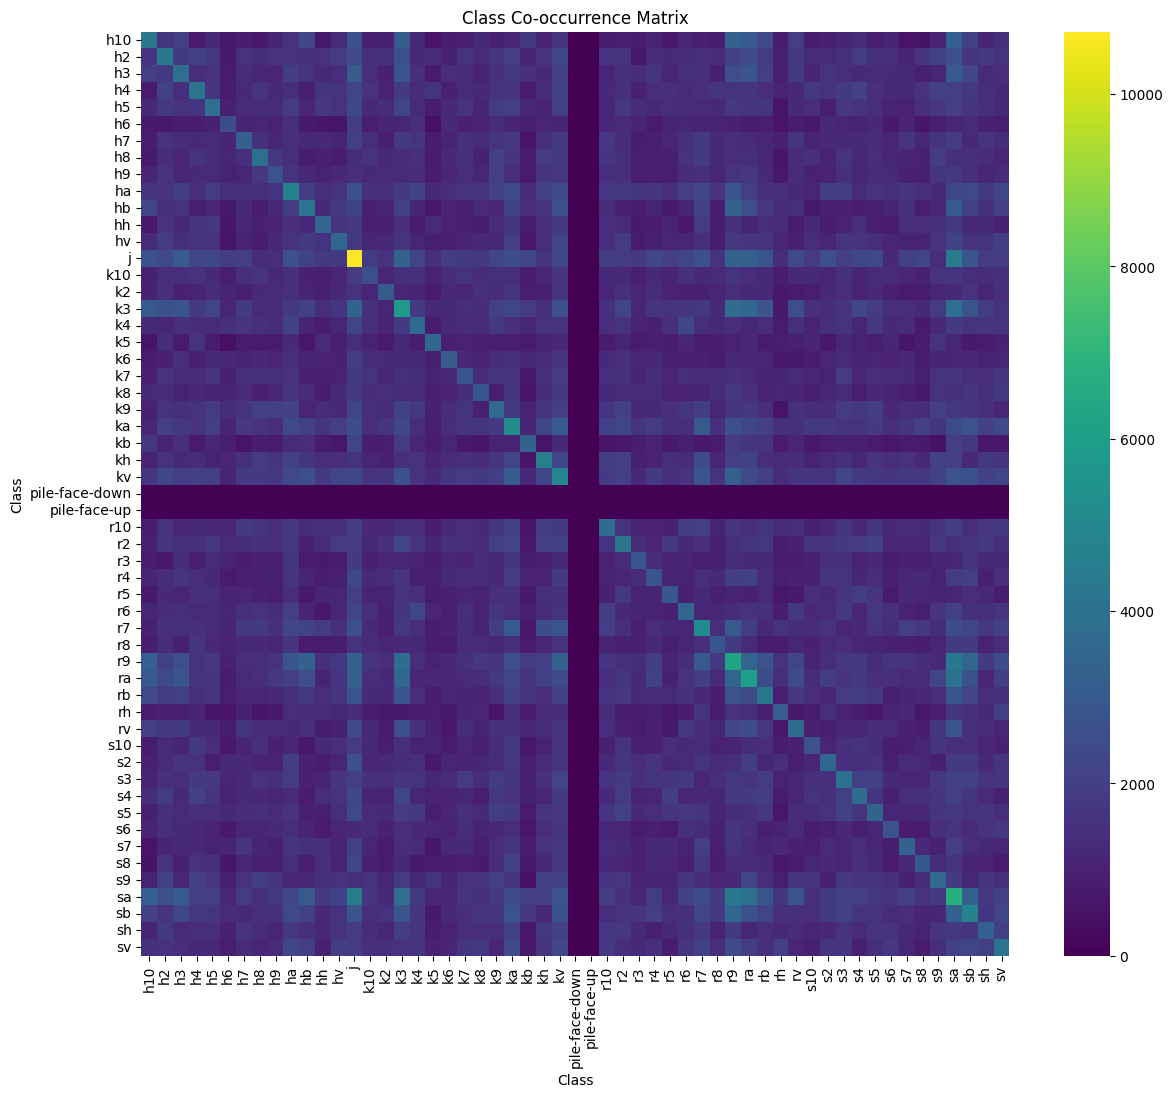

In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Number of classes
n_classes = len(classes)

# Initialize co-occurrence matrix
co_mat = np.zeros((n_classes, n_classes), dtype=int)

# Build matrix
for lf in label_files:
    with open(lf, "r") as f:
        # classes present in this image
        cls_in_img = [int(line.split()[0]) for line in f if line.strip()]

    # Count pairwise co-occurrence
    for c1 in cls_in_img:
        for c2 in cls_in_img:
            co_mat[c1, c2] += 1

# Plot heatmap
plt.figure(figsize=(14,12))
sns.heatmap(
    co_mat,
    xticklabels=classes,
    yticklabels=classes,
    cmap="viridis",
    annot=False
)
plt.title("Class Co-occurrence Matrix")
plt.xlabel("Class")
plt.ylabel("Class")
plt.show()


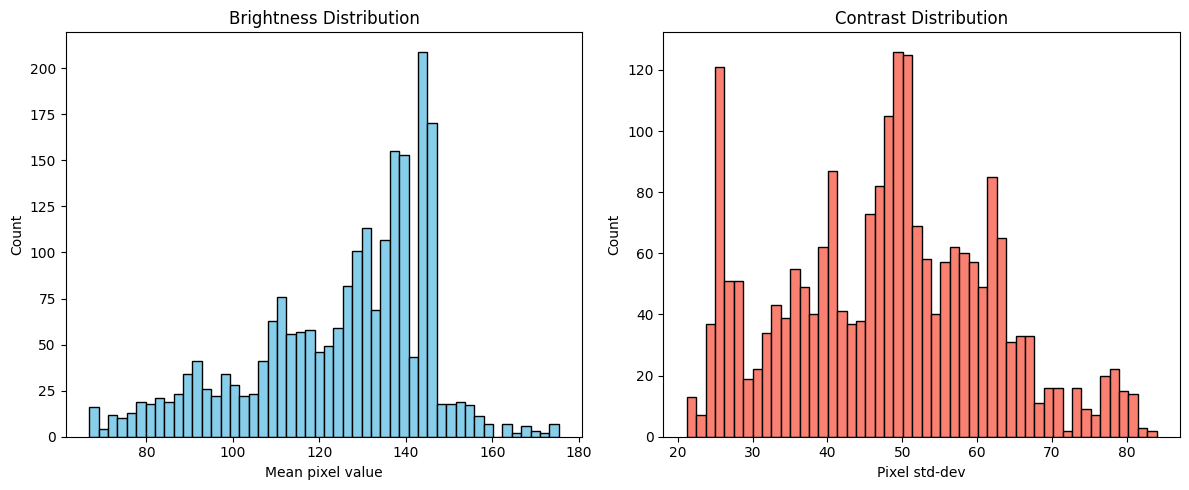

In [27]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

brightness_vals = []
contrast_vals = []

for img_path in img_paths:
    # Load image in grayscale
    img = np.array(Image.open(img_path).convert("L"), dtype=np.float32)

    # Brightness = mean pixel intensity
    brightness_vals.append(img.mean())

    # Contrast = standard deviation of pixel intensity
    contrast_vals.append(img.std())

plt.figure(figsize=(12,5))

# Brightness histogram
plt.subplot(1,2,1)
plt.hist(brightness_vals, bins=50, color='skyblue', edgecolor='black')
plt.title("Brightness Distribution")
plt.xlabel("Mean pixel value")
plt.ylabel("Count")

# Contrast histogram
plt.subplot(1,2,2)
plt.hist(contrast_vals, bins=50, color='salmon', edgecolor='black')
plt.title("Contrast Distribution")
plt.xlabel("Pixel std-dev")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


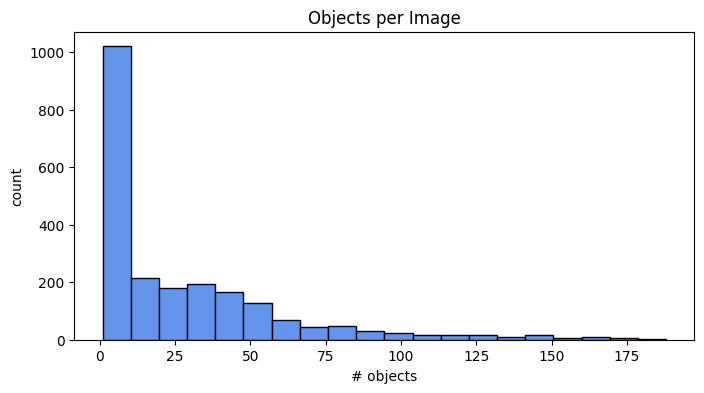

count    2209.000000
mean       28.362608
std        32.470350
min         1.000000
25%         6.000000
50%        12.000000
75%        40.000000
max       188.000000
dtype: float64

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Count number of annotation lines per label file
obj_counts = []

for lf in label_files:
    with open(lf) as f:
        n_objs = sum(1 for _ in f)
        obj_counts.append(n_objs)

# Plot histogram
plt.figure(figsize=(8,4))
plt.hist(obj_counts, bins=20, color="cornflowerblue", edgecolor="black")
plt.title("Objects per Image")
plt.xlabel("# objects")
plt.ylabel("count")
plt.show()

# Summary statistics
pd.Series(obj_counts).describe()


Images with >100 objects: 101


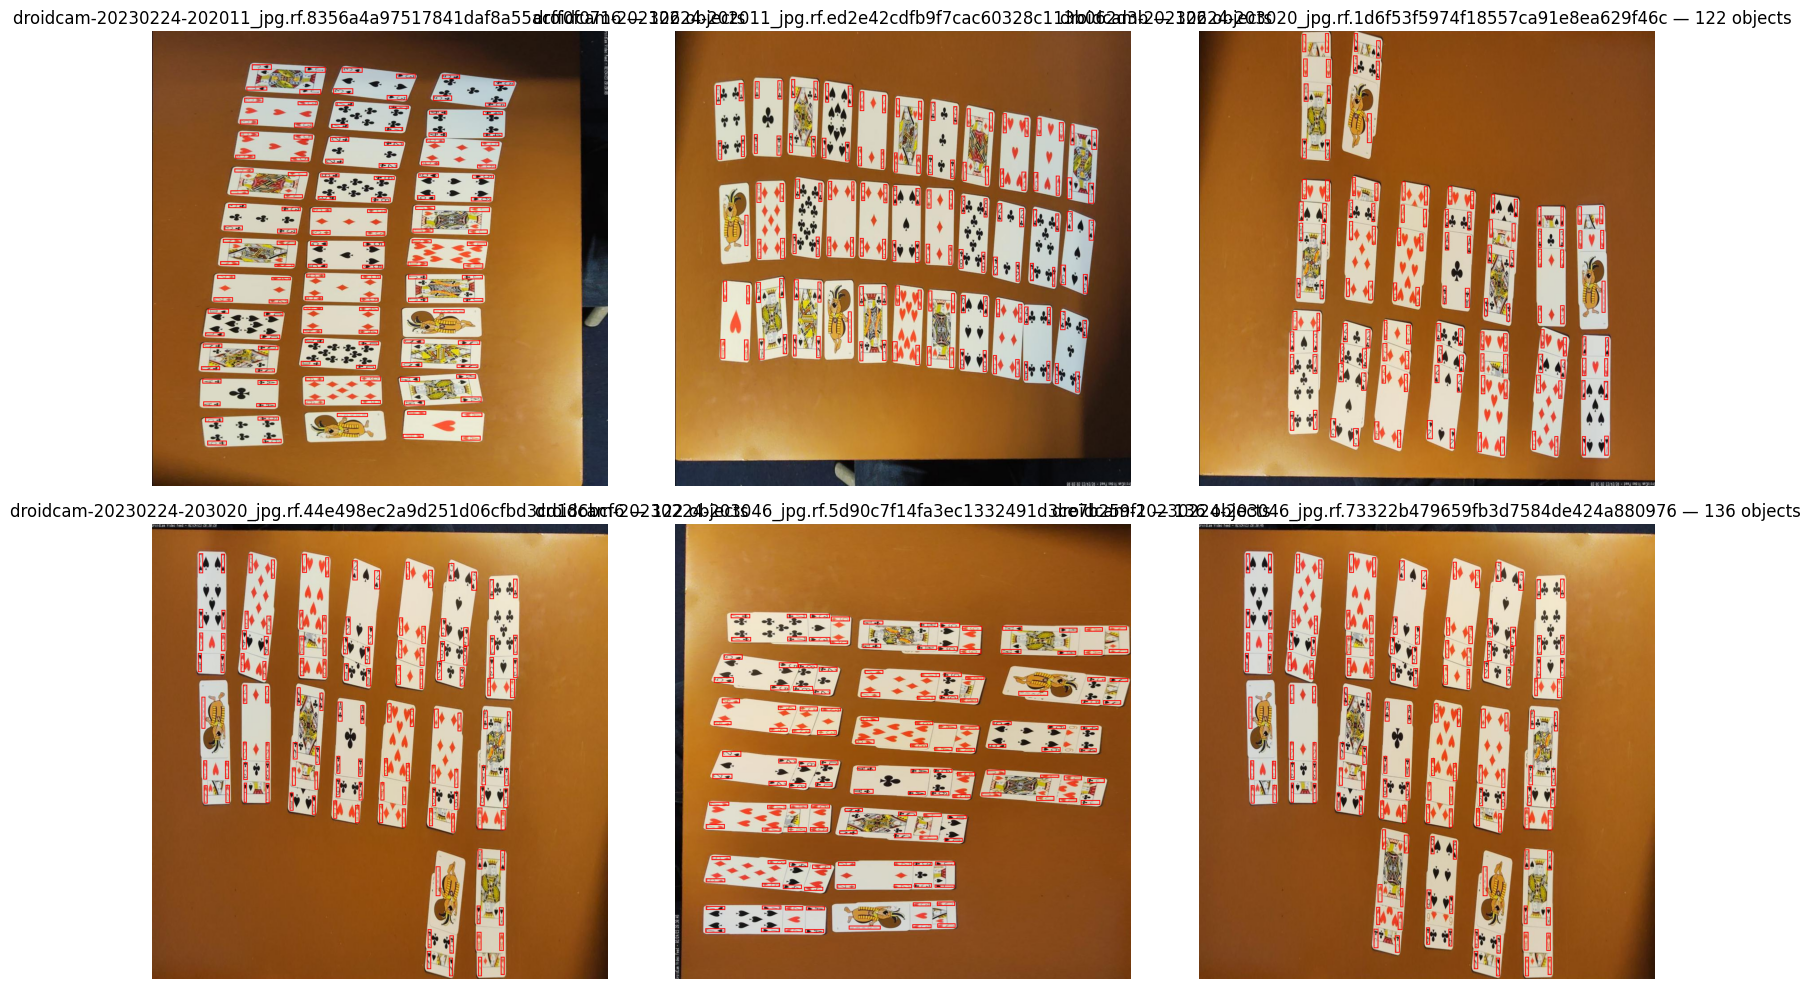

In [29]:
from PIL import ImageDraw
import matplotlib.pyplot as plt

# --- Find label files with >100 objects ---
crowded = []

for lf in label_files:
    with open(lf) as f:
        n = sum(1 for _ in f)
        if n > 100:
            crowded.append((lf, n))

print("Images with >100 objects:", len(crowded))

# If none, stop
if len(crowded) == 0:
    print("No crowded images found.")
else:
    # Visualize up to the first 6 crowded images
    n_show = min(6, len(crowded))

    plt.figure(figsize=(16, 10))

    for i, (lf, n) in enumerate(crowded[:n_show], 1):
        img_path = lf.parent.parent / "images" / (lf.stem + ".jpg")
        if not img_path.exists():
            img_path = lf.parent.parent / "images" / (lf.stem + ".png")

        img = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(img)
        w, h = img.size

        # Draw boxes
        with open(lf) as f:
            for line in f:
                cls, xc, yc, bw, bh = map(float, line.split())
                x1 = (xc - bw/2) * w
                y1 = (yc - bh/2) * h
                x2 = (xc + bw/2) * w
                y2 = (yc + bh/2) * h
                draw.rectangle([x1, y1, x2, y2], outline="red", width=2)

        plt.subplot(2, 3, i)
        plt.imshow(img)
        plt.title(f"{lf.stem} — {n} objects")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


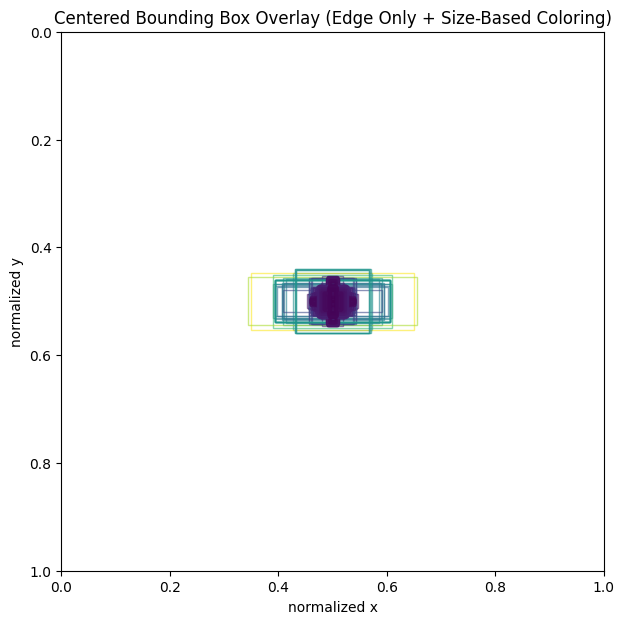

In [30]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

# --- Load test labels only ---
test_label_files = list((root / "test" / "labels").glob("*.txt"))

# Collect sizes first to compute color mapping
areas = []
boxes = []

for lf in test_label_files:
    with open(lf, "r") as f:
        for line in f:
            cls, xc, yc, w, h = map(float, line.split())
            area = w * h
            areas.append(area)
            boxes.append((w, h))

areas = np.array(areas)

# Normalize areas → map to colormap range [0,1]
min_a, max_a = areas.min(), areas.max()
norm_areas = (areas - min_a) / (max_a - min_a)

# Choose a colormap
cmap = plt.cm.viridis  # alternative: plasma, inferno, coolwarm

plt.figure(figsize=(7,7))
ax = plt.gca()

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.invert_yaxis()

xc, yc = 0.5, 0.5
alpha = 0.6  # transparency for outlines

# Draw all boxes centered
for (w, h), norm_a in zip(boxes, norm_areas):
    x1 = xc - w/2
    y1 = yc - h/2

    color = cmap(norm_a)

    rect = Rectangle(
        (x1, y1),
        w,
        h,
        edgecolor=color,
        facecolor="none",   # <<<<< NO FILL!
        linewidth=1,
        alpha=alpha
    )
    ax.add_patch(rect)

plt.title("Centered Bounding Box Overlay (Edge Only + Size-Based Coloring)")
plt.xlabel("normalized x")
plt.ylabel("normalized y")
plt.show()
